In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Environment with cat-awareness in the state
class CheeseEnvironment:
    def __init__(self, size=(15, 10)):
        self.size = size  # (width, height)
        self.reset()
    
    def reset(self):
        self.cheese = [self.size[0]-1, self.size[1]-4]  # cheese at bottom-right corner
        self.mouse = [0, 0]  # mouse starts at top-left
        self.cat = [random.randint(0, self.size[0]-1), random.randint(0, self.size[1]-1)]
        # Ensure cat is not on the cheese or mouse initially.
        while self.cat == self.cheese or self.cat == self.mouse:
            self.cat = [random.randint(0, self.size[0]-1), random.randint(0, self.size[1]-1)]
        return self.get_state()

    def get_state(self):
        # State now includes both the mouse and cat positions.
        return (self.mouse[0], self.mouse[1], self.cat[0], self.cat[1])
    
    def get_reward_mouse(self):
        if self.mouse == self.cheese:
            return 1
        elif self.mouse == self.cat:
            return -20
        else:
            return 0
        
    def get_reward_cat(self):
        if self.mouse == self.cat:
            return 1
        else:
            return -1

    def move_mouse(self, direction):
        # Action mapping: 0 = stay, 1 = left, 2 = down, 3 = right, 4 = up
        if direction == 1:
            self.mouse[0] = max(0, self.mouse[0]-1)
        elif direction == 3:
            self.mouse[0] = min(self.size[0]-1, self.mouse[0]+1)
        elif direction == 2:
            self.mouse[1] = min(self.size[1]-1, self.mouse[1]+1)
        elif direction == 4:
            self.mouse[1] = max(0, self.mouse[1]-1)
        return self.mouse

    def move_cat(self, direction):
        if direction == 1:
            self.cat[0] = max(0, self.cat[0]-1)
        elif direction == 3:
            self.cat[0] = min(self.size[0]-1, self.cat[0]+1)
        elif direction == 2:
            self.cat[1] = min(self.size[1]-1, self.cat[1]+1)
        elif direction == 4:
            self.cat[1] = max(0, self.cat[1]-1)
        return self.mouse

# Q-learning agent with cat-awareness
class CheeseQLearning(object):
    def __init__(self, env, learning_rate=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        # Q_table dimensions: (mouse_x, mouse_y, cat_x, cat_y, action)
        self.q_table_mouse = np.zeros((env.size[0], env.size[1], env.size[0], env.size[1], 5))
        self.q_table_cat = np.zeros((env.size[0], env.size[1], env.size[0], env.size[1], 5))
    
    def choose_action_mouse(self, state):
        # Epsilon-greedy action selection.
        if np.random.rand() < self.epsilon:
            return np.random.randint(5)
        else:
            return np.argmax(self.q_table_mouse[state[0], state[1], state[2], state[3], :])
            

    def choose_action_cat(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(5)
        else:
            return np.argmax(self.q_table_cat[state[0], state[1], state[2], state[3], :])

        
    
    def update_q_table_mouse(self, state, action, reward, next_state):
        best_next = np.max(self.q_table_mouse[next_state[0], next_state[1], next_state[2], next_state[3], :])
        self.q_table_mouse[state[0], state[1], state[2], state[3], action] += self.lr * (
            reward + self.gamma * best_next - self.q_table_mouse[state[0], state[1], state[2], state[3], action]
        )

    def update_q_table_cat(self, state, action, reward, next_state):
        best_next = np.max(self.q_table_cat[next_state[0], next_state[1], next_state[2], next_state[3], :])
        self.q_table_cat[state[0], state[1], state[2], state[3], action] += self.lr * (
            reward + self.gamma * best_next - self.q_table_cat[state[0], state[1], state[2], state[3], action]
        )
    


    def train(self, episodes=500, visualize=False):
        steps_per_episode = []
        for episode in range(episodes):
            if episode % 10000 == 0:
                print(f"Episode {episode}")
            state = self.env.reset()
            done = False
            step = 0
            while not done:
                step += 1
                if visualize:
                    self.visualize_state(episode, step)
                action_mouse = self.choose_action_mouse(state)
                action_cat = self.choose_action_cat(state)

                self.env.move_mouse(action_mouse)
                self.env.move_cat(action_cat)

                next_state = self.env.get_state()
                reward_mouse = self.env.get_reward_mouse()
                reward_cat = self.env.get_reward_cat()
                self.update_q_table_mouse(state, action_mouse, reward_mouse, next_state)
                self.update_q_table_cat(state, action_cat, reward_cat, next_state)
                state = next_state

                # End episode if the mouse reaches the cheese or gets caught by the cat.
                if self.env.mouse == self.env.cheese or self.env.mouse == self.env.cat:
                    done = True
            steps_per_episode.append(step)
        return steps_per_episode
    
    def visualize_state(self, episode, step):
        # Clear previous output and update the plot to create an animation-like effect.
        clear_output(wait=True)
        plt.clf()
        ax = plt.gca()
        width, height = self.env.size
        # Draw grid lines.
        for x in range(width+1):
            ax.plot([x, x], [0, height], color='gray', linewidth=0.5)
        for y in range(height+1):
            ax.plot([0, width], [y, y], color='gray', linewidth=0.5)
        # Plot cheese, mouse, and cat.
        ax.scatter(self.env.cheese[0] + 0.5, self.env.cheese[1] + 0.5, marker='*', s=200, color='gold', label='Cheese')
        ax.scatter(self.env.mouse[0] + 0.5, self.env.mouse[1] + 0.5, marker='o', s=200, color='blue', label='Mouse')
        ax.scatter(self.env.cat[0] + 0.5, self.env.cat[1] + 0.5, marker='v', s=200, color='red', label='Cat')
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)
        ax.set_title(f"Episode {episode+1}, Step {step}")
        ax.legend(loc='upper right')
        plt.pause(0.1)


Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Episode 60000
Episode 70000
Episode 80000
Episode 90000
Episode 100000
Episode 110000
Episode 120000
Episode 130000
Episode 140000
Episode 150000
Episode 160000
Episode 170000
Episode 180000
Episode 190000


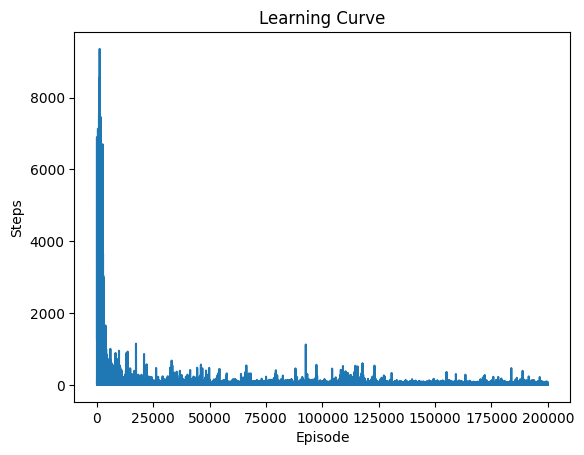

In [6]:
# Example usage:
if __name__ == "__main__":
    env = CheeseEnvironment(size=(15, 10))
    agent = CheeseQLearning(env)
    
    # Train with visualization enabled to see the agent in action.
    steps = agent.train(episodes=200000, visualize=False)
    
    # Plot the learning curve: steps taken per episode.
    plt.figure()
    plt.plot(steps)
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.title("Learning Curve")
    plt.show()

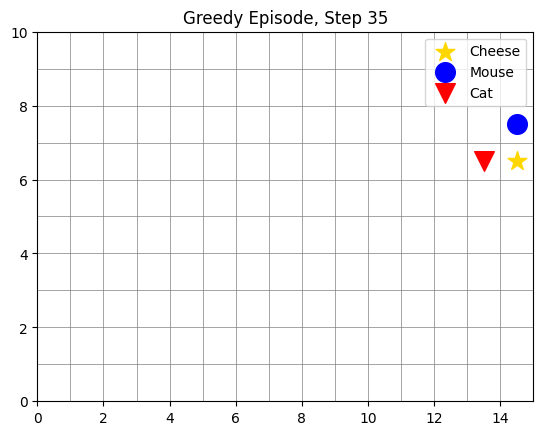

In [13]:

def run_one_episode_greedy(agent, env):
    agent.epsilon = 0.0  # no exploration
    state = env.reset()
    done = False
    step = 0
    
    while not done and step < 200:
        step += 1
        clear_output(wait=True)
        plt.clf()
        ax = plt.gca()
        width, height = env.size
        
        # Draw grid
        for x in range(width+1):
            ax.plot([x, x], [0, height], color='gray', linewidth=0.5)
        for y in range(height+1):
            ax.plot([0, width], [y, y], color='gray', linewidth=0.5)
        
        # Plot cheese, mouse, and cat
        ax.scatter(env.cheese[0]+0.5, env.cheese[1]+0.5, marker='*', s=200, color='gold', label='Cheese')
        ax.scatter(env.mouse[0]+0.5, env.mouse[1]+0.5, marker='o', s=200, color='blue', label='Mouse')
        ax.scatter(env.cat[0]+0.5, env.cat[1]+0.5, marker='v', s=200, color='red', label='Cat')
        
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)
        ax.set_title(f"Greedy Episode, Step {step}")
        ax.legend(loc='upper right')
        plt.pause(0.1)
        
        # Greedy action
        action_mouse = np.argmax(agent.q_table_mouse[state[0], state[1], state[2], state[3], :])
        action_cat = np.argmax(agent.q_table_cat[state[0], state[1], state[2], state[3], :])
        env.move_mouse(action_mouse)
        env.move_cat(action_cat)
        reward_mouse = env.get_reward_mouse()
        reward_cat = env.get_reward_cat()
        state = env.get_state()
        
        if env.mouse == env.cheese or env.mouse == env.cat:
            done = True

    plt.show()

# After training:
run_one_episode_greedy(agent, env)